<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [23]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// needed to generate the Table of contents 
// taken from github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

# Modeling
Importing modules and data from prevoius step


In [24]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [25]:
#Load data and scaler model

X_train_scaled = pd.read_csv("../data/X_train_scaled.csv").to_numpy()
y_train = pd.read_csv("../data/y_train.csv").to_numpy().ravel()
X_test_scaled = pd.read_csv("../data/X_test_scaled.csv").to_numpy()
y_test = pd.read_csv("../data/y_test.csv").to_numpy().ravel()
feature_list = pd.read_csv("../data/feature_list.csv")
feature_list = pd.Index(list(feature_list["0"]))

scaler = joblib.load("../data/scaler.pkl")

## Fit Models with Training Data Set

### Baseline model (does not behave. Skip for now)
Based on the istribution of the lifetimes of the dataset we choose the thresholds for our baseline model as:
- if cycle time is < 150 : Green
- if cycle time is < 200 : Yellow
- if cycle time is > 200 : Red

This is similar to a adopting a *scheduled maintenance* model where if the engine is above 150 cycles, we want to schedule service, if the engine is above 200 cycles, we urgently need to schedule service. 

![Distribution of Lifetimes](../figures/lifetimes_ecdf.png)





In [42]:
strategies = ['most_frequent', 'stratified', 'prior', 'uniform']

for s in tqdm(strategies) :
    res = try_model(DummyClassifier(strategy=s), X_train_scaled, y_train, X_test_scaled, y_test)
    models_summary = models_summary.append(res, ignore_index=True)


Trying Model :DummyClassifier(strategy='most_frequent')
|  Train Score: 0.515
|  Test Score: 0.761
Trying Model :DummyClassifier(strategy='stratified')
|  Train Score: 0.379
|  Test Score: 0.445
Trying Model :DummyClassifier(strategy='prior')
|  Train Score: 0.515
|  Test Score: 0.761
Trying Model :DummyClassifier(strategy='uniform')
|  Train Score: 0.334
|  Test Score: 0.329



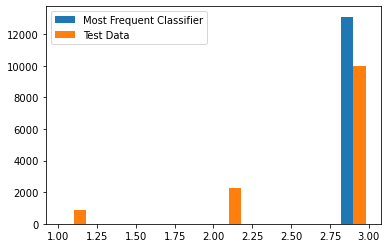

In [87]:
clf_dummy = DummyClassifier(strategy='most_frequent').fit(X_train_scaled, y_train)
y_dummy = clf_dummy.predict(X_test_scaled)
plt.hist([y_dummy, y_test])
plt.legend(['Most Frequent Classifier', 'Test Data'])

<ipython-input-26-bc73d503e58d>:64: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]


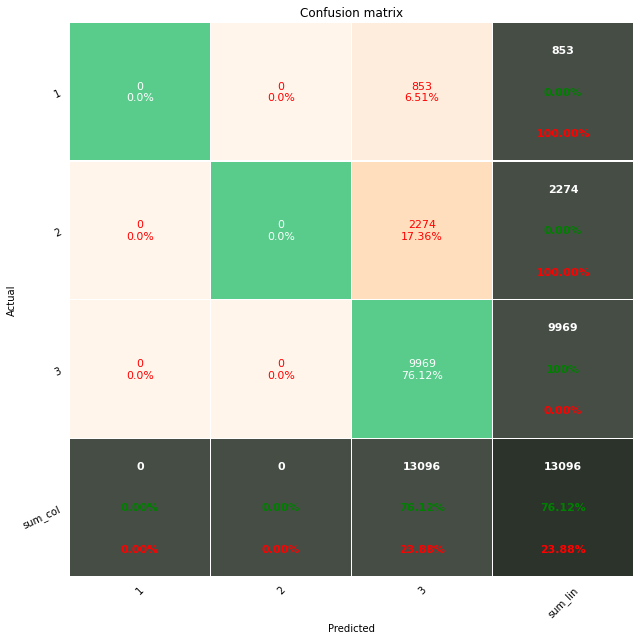

In [89]:
plot_confusion_matrix_from_data(y_test, y_dummy, columns=[1,2,3], annot=True, pred_val_axis='col')

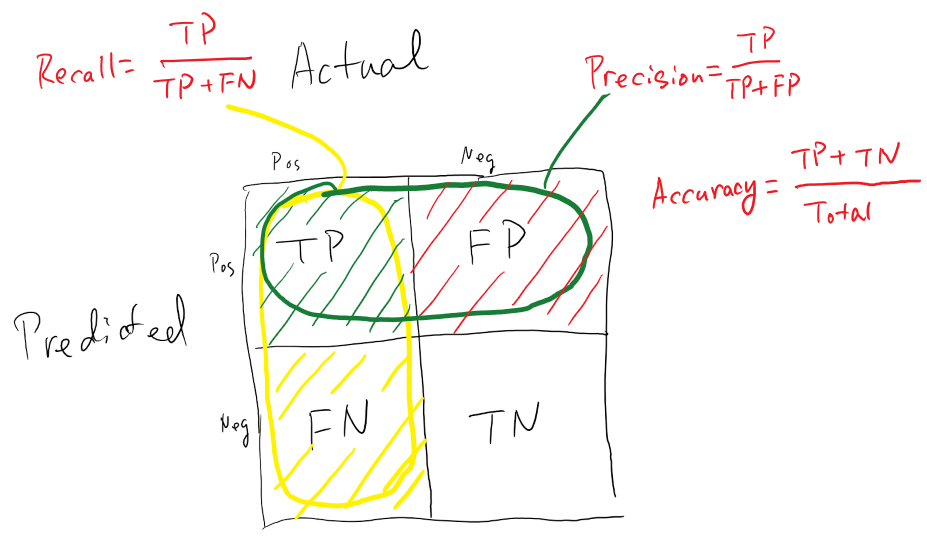

--> The Dummy Classifier: Most Frequent has 0.761 Accuracy!

In [26]:
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#



#
#TEST functions
#
def _test_cm():
    #test function with confusion matrix done
    array = np.array( [[13,  0,  1,  0,  2,  0],
                       [ 0, 50,  2,  0, 10,  0],
                       [ 0, 13, 16,  0,  0,  3],
                       [ 0,  0,  0, 13,  1,  0],
                       [ 0, 40,  0,  1, 15,  0],
                       [ 0,  0,  0,  0,  0, 20]])
    #get pandas dataframe
    df_cm = DataFrame(array, index=range(1,7), columns=range(1,7))
    #colormap: see this and choose your more dear
    cmap = 'PuRd'
    pretty_plot_confusion_matrix(df_cm, cmap=cmap)
#

def _test_data_class():
    """ test function with y_test (actual values) and predictions (predic) """
    #data
    y_test = np.array([1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5])
    predic = np.array([1,2,4,3,5, 1,2,4,3,5, 1,2,3,4,4, 1,4,3,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,3,3,5, 1,2,3,3,5, 1,2,3,4,4, 1,2,3,4,1, 1,2,3,4,1, 1,2,3,4,1, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5])
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    columns = []
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 12;
    figsize = [9,9];
    if(len(y_test) > 10):
        fz=9; figsize=[14,14];
    plot_confusion_matrix_from_data(y_test, predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)
#


# #
# #MAIN function
# #
# if(__name__ == '__main__'):
#     print('__main__')
#     print('_test_cm: test function with confusion matrix done\nand pause')
#     _test_cm()
#     plt.pause(5)
#     print('_test_data_class: test function with y_test (actual values) and predictions (predic)')
#     _test_data_class()

In [27]:
def Baseline_predict (X) :
    """Makes the baseline prediction
    It considers only the cycle_time column X[0]
    if x < 150 --> 3
    if 150 < x < 200 -->2
    if x >= 200 --> 1"""
    green = 150 # normal = 3
    yellow = 200 # warning = 2
    # alarm = 1
    y_pred = [3 if x < green else 2 if x < yellow else 1 for x in X[:,0]]
    #check_service = lambda x : (3 if x < green else (2 if x < yellow else 1)) 
    # = [(3 if x < green else (2 if x < yellow else 1)) for x in X]
    return np.array(y_pred)

In [29]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

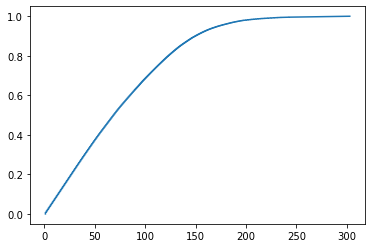

In [30]:
x,y = ecdf(scaler.inverse_transform(X_test_scaled)[:,0])
plt.plot(x,y)

[1 2 3]
[  259  1061 11776]


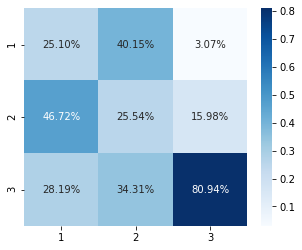

In [86]:
y_baseline = Baseline_predict(scaler.inverse_transform(X_test_scaled))
baseline_conf_matrix = confusion_matrix(y_test, y_baseline)
#print(baseline_conf_matrix)
df_cm = pd.DataFrame(baseline_conf_matrix, index = [1,2,3],
                  columns = [1,2,3])
plt.figure(figsize = (5,4))
#_ = sns.heatmap(df_cm, annot=True, cmap='Blues')
_ = sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='Blues')


unique_elements, counts_elements =  np.unique(y_baseline, return_counts=True)
print(unique_elements)
print(counts_elements)

<ipython-input-26-bc73d503e58d>:64: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]


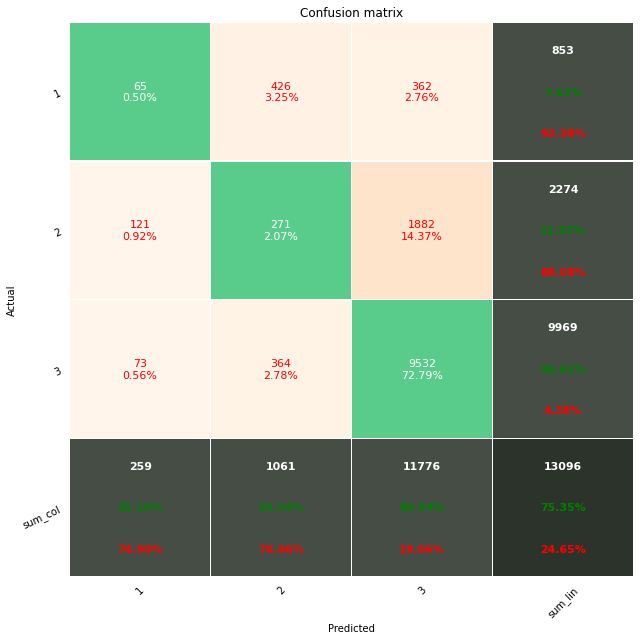

In [32]:
plot_confusion_matrix_from_data(y_test, y_baseline, columns=[1,2,3], annot=True, pred_val_axis='col')

In [33]:
train_df = pd.DataFrame(X_train_scaled, columns = feature_list)
train_df

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.000000,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.002770,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.005540,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.008310,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.011080,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.540166,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500
20627,0.542936,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197
20628,0.545706,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991
20629,0.548476,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466


In [34]:
test_df = pd.DataFrame(X_test_scaled, columns = feature_list)
test_df

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.000000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834
1,0.002770,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827
2,0.005540,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348
3,0.008310,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110
4,0.011080,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,0.534626,0.611446,0.619359,0.566172,0.573269,0.181818,0.541326,0.500000,0.426439,0.176471,0.584890,0.564063,0.500000,0.395349,0.418669
13092,0.537396,0.605422,0.537388,0.671843,0.542673,0.227273,0.533743,0.446429,0.503198,0.308824,0.572350,0.485956,0.583333,0.333333,0.528721
13093,0.540166,0.671687,0.482014,0.414754,0.513688,0.318182,0.561249,0.428571,0.530917,0.235294,0.605326,0.507888,0.583333,0.372093,0.429301
13094,0.542936,0.617470,0.522128,0.626435,0.566828,0.257576,0.570403,0.452381,0.562900,0.294118,0.622046,0.562524,0.583333,0.403101,0.518779


### Test stock models (Default Parameters)
- KNeighborsClassifier
- SVC - Linear and RBF
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- GradientBoostingClassifier




In [39]:
def try_model(model, X_train, y_train, X_test, y_test):
    """ Fits a model on the selected data with the default parameters 
    ex. usage 
        summary = try_model(KNeighborsClassifier(),X_train, y_train)"""
    # statements
    print('Trying Model :'+ str(model))
    start = timer()
    model.fit(X_train, y_train)
    middle = timer()
    test_score = model.score(X_test, y_test)
    end = timer()
    train_score = model.score(X_train, y_train) 
    
    # calculate confusion matrix
    
    
    print('|  Train Score: ' + str(round(train_score,3)))
    print('|  Test Score: ' + str(round(test_score,3)))
    
    train_elapsed = round(middle - start,3)
    test_elapsed = round(end - middle,3)

    summary = {'model': str(model),
               'training time [s]': train_elapsed,
               'test time [s]': test_elapsed,
               'test accuracy': test_score,
               'train accuracy': train_score}
    #print(summary)
    return summary

In [40]:
models_summary = pd.DataFrame()
models_to_try = [GridSearchCV(DecisionTreeClassifier(),{'criterion':['gini', 'entropy'],'max_depth':np.arange(1,5,1)},cv=5),
                 KNeighborsClassifier(),
                 KNeighborsClassifier(n_neighbors=21),
                 DecisionTreeClassifier(),
                 DecisionTreeClassifier(criterion='gini',max_depth=3),
                 RandomForestClassifier(),
                 SVC(),
                 AdaBoostClassifier(),
                 GradientBoostingClassifier(),
                 KNeighborsClassifier(3),
                 SVC(kernel="linear", C=0.025),
                 RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
                ]


In [19]:
for m in tqdm(models_to_try) :
    res = try_model(m, X_train_scaled, y_train, X_test_scaled, y_test)
    models_summary = models_summary.append(res, ignore_index=True)
    


NameError: name 'models_to_try' is not defined

In [20]:
models_summary.sort_values(by=['train accuracy'], ascending=False)

KeyError: 'train accuracy'

### Let's explore Decision Tree and see why I get 100% accuracy -> overfitting

test score : 0.763
train score : 1.0
[0.35335179 0.0316154  0.02652384 0.0466224  0.04402992 0.0237601
 0.07692186 0.18111276 0.04716883 0.0239319  0.04132702 0.03038472
 0.01120048 0.02599524 0.03605375]


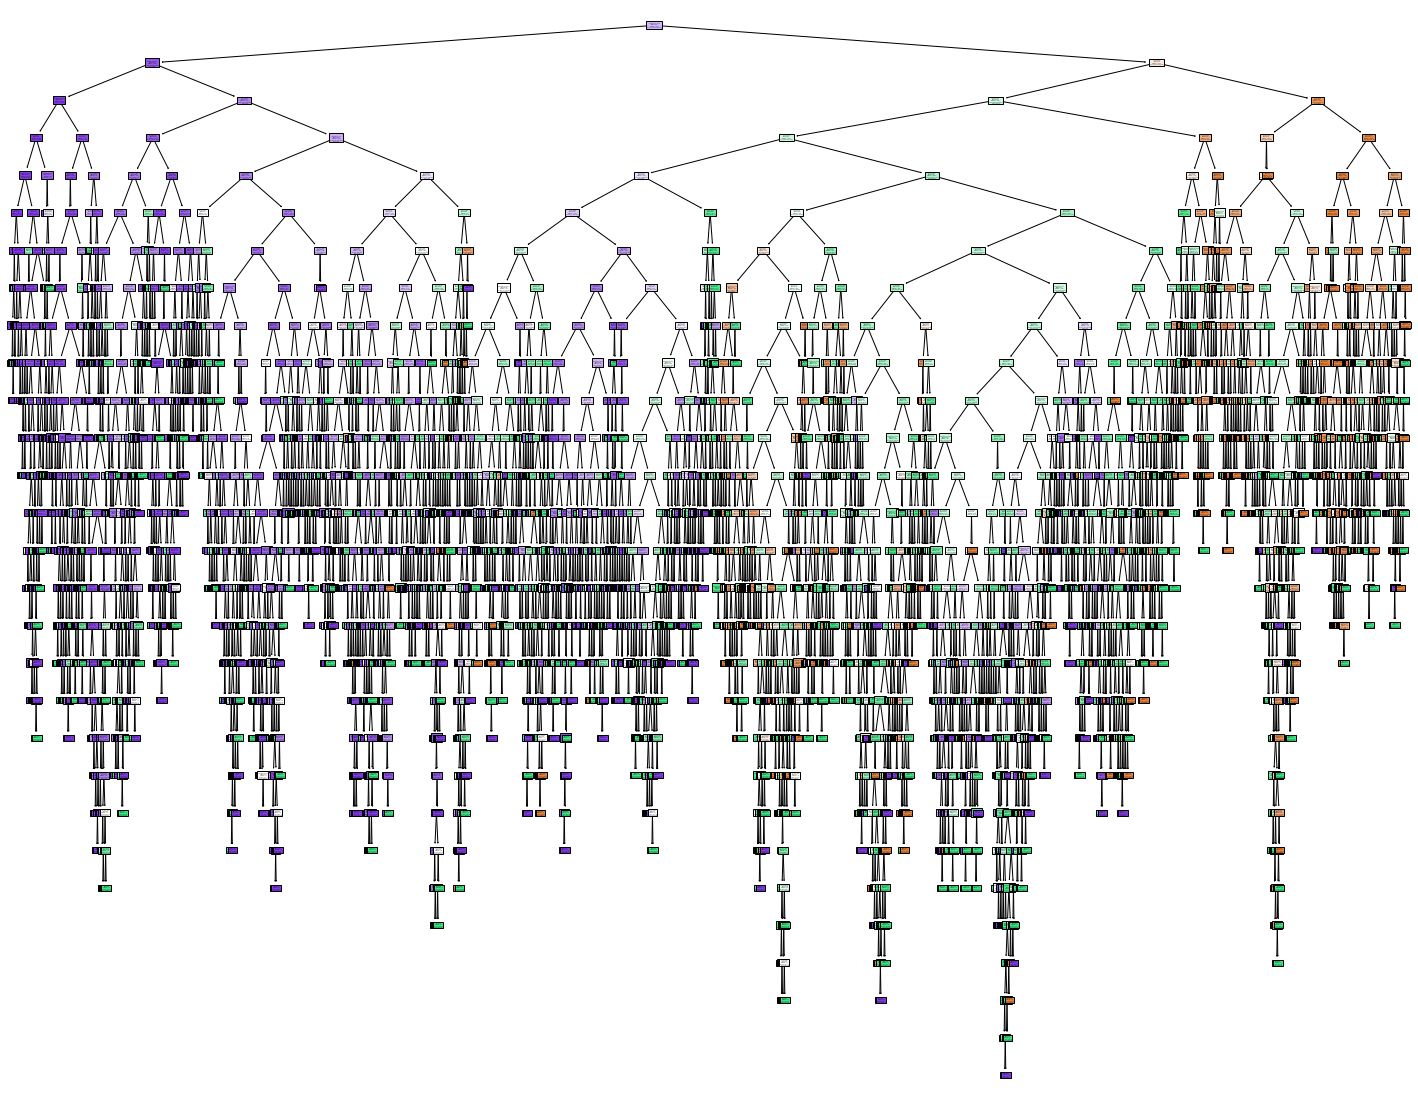

In [38]:
m = DecisionTreeClassifier()
m.fit(X_train_scaled, y_train)
test_score = m.score(X_test_scaled, y_test)
print("test score : "+ str(round(test_score,3)))
train_score = m.score(X_train_scaled, y_train)
print("train score : "+ str(round(train_score,3)))
# print best predictors
print(str(m.feature_importances_))

from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m, 
                   feature_names=feature_list,  
                   class_names=['green','yellow','red'],
                   filled=True)

### GridSearchCV
- KNeighborsClassifier
- SVC - Linear and RBF
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- GradientBoostingClassifier




In [39]:
# Nearest Neighbors


param_grid = {'n_neighbors':np.arange(1,101,10)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,param_grid,cv=5)
start = timer()
knn_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

65.52 seconds elapsed.
Best Score:0.7895866350027443
Best Parameters: {'n_neighbors': 81}


In [67]:
# Decision Tree
param_grid = {'criterion':['gini', 'entropy'],
              'max_depth':np.arange(2,10,1),
              }
tree = DecisionTreeClassifier()
tree_cv= GridSearchCV(tree,param_grid,cv=5)
start = timer()
tree_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')
print("Best CV Score:" + str(tree_cv.best_score_))
print("Best Parameters: " + str(tree_cv.best_params_))
#print(str(tree_cv.best_estimator_.feature_importances_))
print("Best Test Score:" + str(tree_cv.score(X_test_scaled, y_test)))

8.24 seconds elapsed.
Best CV Score:0.7769353327536607
Best Parameters: {'criterion': 'entropy', 'max_depth': 5}
Best Test Score:0.8101710445937691


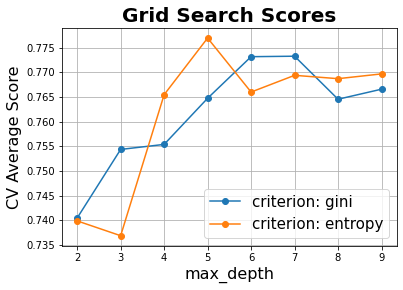

In [75]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(tree_cv.cv_results_, param_grid['max_depth'], param_grid['criterion'], 'max_depth', 'criterion' )

In [41]:
# Random Forest
param_grid = {'n_estimators':np.arange(50,201,50),
              'criterion':['gini', 'entropy'],
              'max_depth':np.arange(1,11,2),
              }
rfc = RandomForestClassifier()
rfc_cv= GridSearchCV(rfc,param_grid,cv=5)
start = timer()
rfc_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')
print("Best Score:" + str(rfc_cv.best_score_))
print("Best Parameters: " + str(rfc_cv.best_params_))

405.844 seconds elapsed.
Best Score:0.7919128856104198
Best Parameters: {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}


In [42]:
# Suppor Vector Classifier - Linear
param_grid = {'C' : np.arange(1,100,10),
              'kernel': ['linear'],
              'gamma' : ['sacle','auto'],
              }
svc = SVC()
svc_cv = GridSearchCV(svc,param_grid,cv=5)
start = timer()
svc_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')
print("Best Score:" + str(svc_cv.best_score_))
print("Best Parameters: " + str(svc_cv.best_params_))

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/svm/_base.py", line 205, in fit
    raise ValueError(
ValueError: When 'gamma' is a string, it should be either 'scale' or 'auto'. Got 'sacle' instead.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/svm/_base.py", line 205, in fit
    raise ValueError(
ValueError: When 'gamma' is a string, it should be either 'scale' or 'auto'. Got 'sacle' instead.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/svm/_base.py", line 205, in fit
    raise ValueError(
ValueError: When 'gamma' is a string, it should be either 'scale' or 'auto'. Got 'sacle' instead.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/svm/_base.py", line 205, in fit
    raise ValueError(
ValueError: When 'gamma' is a string, it should be either 'scale' or 'auto'. Got 'sacle' instead.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan

295.303 seconds elapsed.
Best Score:0.7844008592434978
Best Parameters: {'C': 71, 'gamma': 'auto', 'kernel': 'linear'}


In [43]:
# Suppor Vector Classifier - RBF
param_grid = {'C' : np.arange(1,100,10),
              'kernel': ['rbf'],
              'gamma' : ['scale','auto'],
              }
svc = SVC()
svc_cv = GridSearchCV(svc,param_grid,cv=5)
start = timer()
svc_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')
print("Best Score:" + str(svc_cv.best_score_))
print("Best Parameters: " + str(svc_cv.best_params_))

985.247 seconds elapsed.
Best Score:0.7926402522151454
Best Parameters: {'C': 91, 'gamma': 'auto', 'kernel': 'rbf'}


In [44]:
# AdaBoost
param_grid = {'n_estimators': [10,20,30,40,50],
              'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1]
              }
ada = AdaBoostClassifier()
ada_cv= GridSearchCV(ada,param_grid,cv=5)
start = timer()
ada_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')
print("Best Score:" + str(ada_cv.best_score_))
print("Best Parameters: " + str(ada_cv.best_params_))

95.905 seconds elapsed.
Best Score:0.7772744095284931
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}


In [45]:
# GradientBoosting
param_grid = {'n_estimators': [10,20,30,40,50],
              'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
              'max_features': [2,3,4,5,6,7,8,9],
              'max_depth' : [2,3,4,5,6]
              }
gbc = GradientBoostingClassifier()
gbc_cv= GridSearchCV(gbc,param_grid,cv=5)
start = timer()
gbc_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')
print("Best Score:" + str(gbc_cv.best_score_))
print("Best Parameters: " + str(gbc_cv.best_params_))

14496.398 seconds elapsed.
Best Score:0.7946755702753618
Best Parameters: {'learning_rate': 0.5, 'max_depth': 2, 'max_features': 3, 'n_estimators': 20}


In [47]:
# XGBoost
from xgboost import XGBClassifier
param_grid = {
    'learning_rate': np.arange(0.01, 1.0,0.5),
    'n_estimators': np.arange(100, 1000,500),
    'max_depth': np.arange(3,10,3),
    'gamma': np.arange(0, 5,2)}

xgb = XGBClassifier()
xgb_cv= GridSearchCV(xgb,param_grid,cv=3)
start = timer()
xgb_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')

#print("Best Score:" + str(xgb_cv.best_score_))
#print("Best Parameters: " + str(xgb_cv.best_params_))

1105.971 seconds elapsed.


In [52]:
print("Best Score:" + str(xgb_cv.best_score_))
print("Best Parameters: " + str(xgb_cv.best_params_))

Best Score:0.7853715282826815
Best Parameters: {'gamma': 4, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600}


## Review Model Outcomes — Iterate over additional models as needed.
-> pick top 2  and run hyperparameters tuning


## Bayesian Optimization

```python
def hyperparam_loss(param_x, param_y):
    
    # 1. Define machine learning model using param_x, param_y as hyper parameters
    # 2. Train the model
    # 3. Calculate loss on cross-validation set
    
    return loss
```

In [ ]:
# Decision Tree
param_grid = {'criterion':['gini', 'entropy'],
              'max_depth':np.arange(1,11,2),
              }
tree = DecisionTreeClassifier()
tree_cv= GridSearchCV(tree,param_grid,cv=5)
start = timer()
tree_cv.fit(X_train_scaled,y_train)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')
print("Best Score:" + str(tree_cv.best_score_))
print("Best Parameters: " + str(tree_cv.best_params_))

In [ ]:
# Let's rewrite this in Bayesian Optimization terms

#DecisionTree

#def tree__hyper_param():
    

In [ ]:
# from bayes_opt import BayesianOptimization

# name = names[0]
# model = classifiers[0]

# params_boundaries = {'n_neighbors':(3,11)}

# def kNN_hyper_param(n_neighbors):
#     clf = KNeighborsClassifier(n_neighbors)
       
#     return np.mean(cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy'))

# optimizer = BayesianOptimization(f=kNN_hyper_param, pbounds=params_boundaries, random_state = 33)
# optimizer.maximize(n_iter=5, init_points=2)

In [60]:
from bayes_opt import BayesianOptimization
# XGBoost
from xgboost import XGBClassifier

pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [61]:
start = timer()
optimizer.maximize(n_iter=10, init_points=2)
end = timer()
print(str(round(end - start,3)) + ' seconds elapsed.')

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.7838   |  1.0      |  3.602    |  0.01011  |  5.116    |  232.1    |  1.0      |
|  2        |  0.7783   |  1.0      |  1.728    |  0.4028   |  6.772    |  477.3    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  3        |  0.7791   |  1.0      |  3.284    |  0.7515   |  4.453    |  233.0    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  4        |  0.7844   |  1.0      |  4.72     |  0.2956   |  4.045    |  665.9    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  5        |  0.7774   |  1.0      |  0.8347   |  0.2352   |  4.089    |  952.6    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  6        |  0.7851   |  1.0      |  4.785    |  0.07019  |  4.223    |  666.0    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  7        |  0.785    |  1.0      |  4.794    |  0.1276   |  5.191    |  665.5    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  8        |  0.7791   |  1.0      |  3.616    |  0.6059   |  6.732    |  230.7    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  9        |  0.7842   |  1.0      |  3.407    |  0.07839  |  5.081    |  666.5    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  10       |  0.7809   |  1.0      |  4.878    |  0.8835   |  4.976    |  666.7    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  11       |  0.784    |  1.0      |  3.265    |  0.05982  |  4.869    |  664.4    |  1.0      |


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/scipy/optimize/_num

|  12       |  0.7829   |  1.0      |  4.248    |  0.2836   |  6.286    |  664.0    |  1.0      |
411.649 seconds elapsed.


In [63]:
optimizer.max

{'target': 0.7851291745431631,
 'params': {'colsample': 1.0,
  'gamma': 4.785370576396621,
  'learning_rate': 0.07019473359478108,
  'max_depth': 4.223043194894675,
  'n_estimators': 665.9530526559142,
  'subsample': 1.0}}

## Identify the Final Model
choose final model and make predictions